# Spatio-temporal tradeoff

Replicating the results from Mohler et al in *The Concentration-Dynamics Tradeoff in Crime Hot Spotting*

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from spatial import get_force_boundary, map_to_spatial_unit
from utils import Month, MonthRange, extract_crime_data

In [37]:
FORCE = "West Yorkshire"
filter = {"Crime type": "Anti-social behaviour"}
grid_size = 200
boundary = get_force_boundary(FORCE)
raw_crime_data = extract_crime_data(FORCE, filters=filter)

In [38]:
crime_data, features = map_to_spatial_unit(raw_crime_data, boundary, "GRID", size=grid_size)
# remove any outside force boundary
crime_data = crime_data[~crime_data.spatial_unit.isna()]
crime_data.Month = crime_data.Month.map(Month.parse_str)
crime_data

,spatial_unit,BNG_E,BNG_N,LAT,LONG,Month,Reported by,Falls within,Location,LSOA code,LSOA name,Crime type,geometry
Crime ID,,,,,,,,,,,,,
NaN,28724.0,411300.0,447100.0,53.919920,-1.829433,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Queen'S Gardens,E01010692,Bradford 001D,Anti-social behaviour,POINT (411354.013 447133.948)
NaN,29477.0,411900.0,447700.0,53.925299,-1.820274,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Bus/Coach Station,E01010692,Bradford 001D,Anti-social behaviour,POINT (411854.969 447613.948)
NaN,29225.0,411700.0,447300.0,53.921709,-1.823335,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Wells Road,E01010692,Bradford 001D,Anti-social behaviour,POINT (411758.03 447302.948)
NaN,29477.0,411900.0,447700.0,53.925299,-1.820274,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Bus/Coach Station,E01010692,Bradford 001D,Anti-social behaviour,POINT (411854.969 447613.948)
NaN,29976.0,412300.0,447500.0,53.923493,-1.814191,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Springs Lane,E01010691,Bradford 002A,Anti-social behaviour,POINT (412391.978 447481.039)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,72793.0,446700.0,410900.0,53.592605,-1.295921,2025-04,West Yorkshire Police,West Yorkshire Police,On or near John Street,E01011863,Wakefield 044D,Anti-social behaviour,POINT (446750.007 410878.044)
NaN,72541.0,446500.0,410500.0,53.589027,-1.299002,2025-04,West Yorkshire Police,West Yorkshire Police,On or near Beech Street,E01011863,Wakefield 044D,Anti-social behaviour,POINT (446414.024 410431.008)
NaN,72793.0,446700.0,410900.0,53.592605,-1.295921,2025-04,West Yorkshire Police,West Yorkshire Police,On or near Princess Avenue,E01011863,Wakefield 044D,Anti-social behaviour,POINT (446666.975 410800.005)


In [39]:
start_months = list(MonthRange(crime_data.Month.min(), end=crime_data.Month.max()))
timespan = [sum(m.days for m in start_months[i:]) for i in range(len(start_months))]

In [ ]:
land_area = pd.DataFrame(index=timespan, columns=["25% of crime", "50% of crime"])

for start_month, days in zip(start_months, timespan):
    # dont need a spatial join, just need to reindex on all the features
    sample = (
        crime_data[crime_data.Month >= start_month]
        .groupby("spatial_unit")["Crime type"]
        .count()
        .rename("total")
        .reindex(features.index, fill_value=0)
    ).sort_values()
    cumulative = sample.cumsum() / sample.sum()
    land_area.loc[days, "25% of crime"] = 100 * len(cumulative[cumulative >= 0.75]) / len(cumulative)
    land_area.loc[days, "50% of crime"] = 100 * len(cumulative[cumulative >= 0.5]) / len(cumulative)

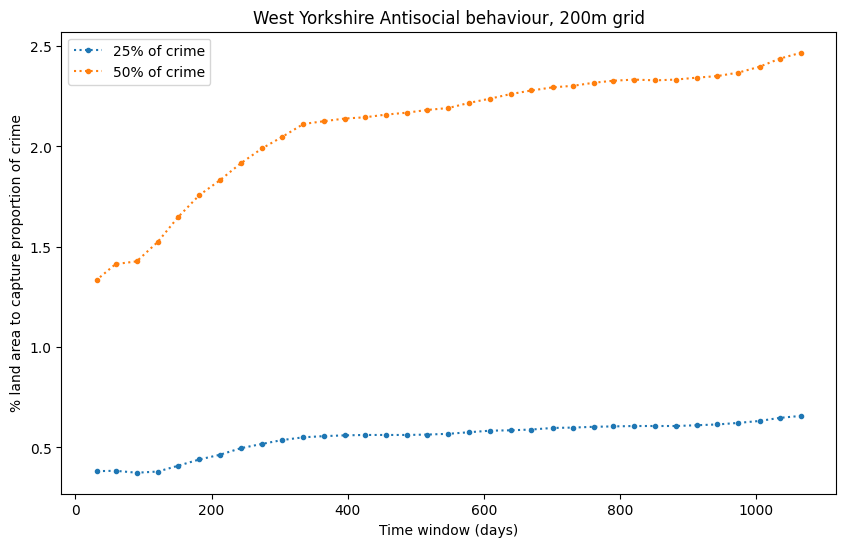

In [41]:
land_area.plot(
    marker=".",
    ls=":",
    ylabel="% land area to capture proportion of crime",
    xlabel="Time window (days)",
    title=f"West Yorkshire Antisocial behaviour, {grid_size}m grid",
    figsize=(10, 6),
);

In [ ]:
overlap = pd.DataFrame(index=timespan[:-1], columns=["25% of crime", "50% of crime"])

sample = (
    crime_data[crime_data.Month == start_month]
    .groupby("spatial_unit")["Crime type"]
    .count()
    .rename("total")
    .reindex(features.index, fill_value=0)
).sort_values()
cumulative = sample.cumsum() / sample.sum()
prev_locations25 = cumulative[cumulative >= 0.75].index
prev_locations50 = cumulative[cumulative >= 0.5].index

for start_month, days in list(zip(reversed(start_months), reversed(timespan)))[1:]:
    sample = (
        crime_data[crime_data.Month >= start_month]
        .groupby("spatial_unit")["Crime type"]
        .count()
        .rename("total")
        .reindex(features.index, fill_value=0)
    ).sort_values()
    cumulative = sample.cumsum() / sample.sum()

    locations25 = cumulative[cumulative >= 0.75].index
    locations50 = cumulative[cumulative >= 0.5].index

    overlap25 = (
        100 * len(np.intersect1d(locations25, prev_locations25)) / len(np.union1d(locations25, prev_locations25))
    )
    overlap50 = (
        100 * len(np.intersect1d(locations50, prev_locations50)) / len(np.union1d(locations50, prev_locations50))
    )

    overlap.loc[days, "25% of crime"] = overlap25
    overlap.loc[days, "50% of crime"] = overlap50

    prev_locations25 = locations25
    prev_locations50 = locations50

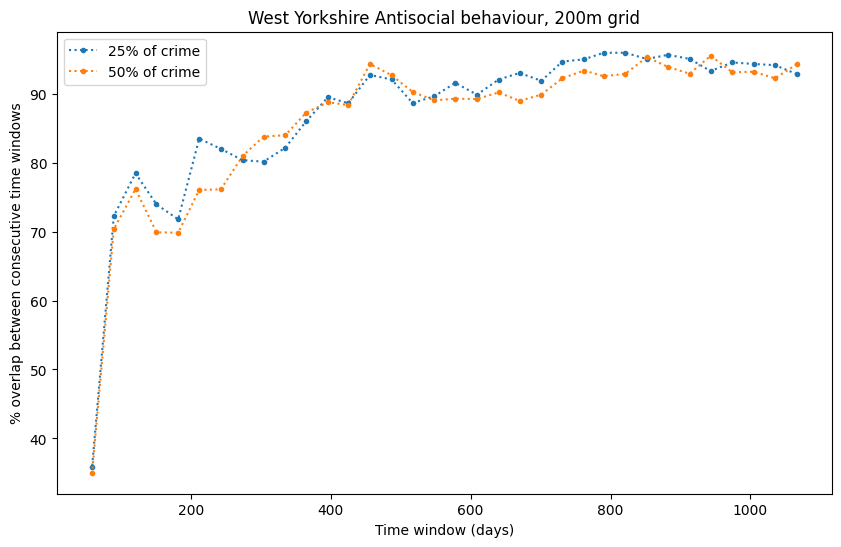

In [43]:
overlap.plot(
    marker=".",
    ls=":",
    ylabel="% overlap between consecutive time windows",
    xlabel="Time window (days)",
    title=f"West Yorkshire Antisocial behaviour, {grid_size}m grid",
    figsize=(10, 6),
);

In [44]:
both = land_area.join(overlap, lsuffix="_land_area").reset_index(names="days")
# both = both.head(len(both) - 2)

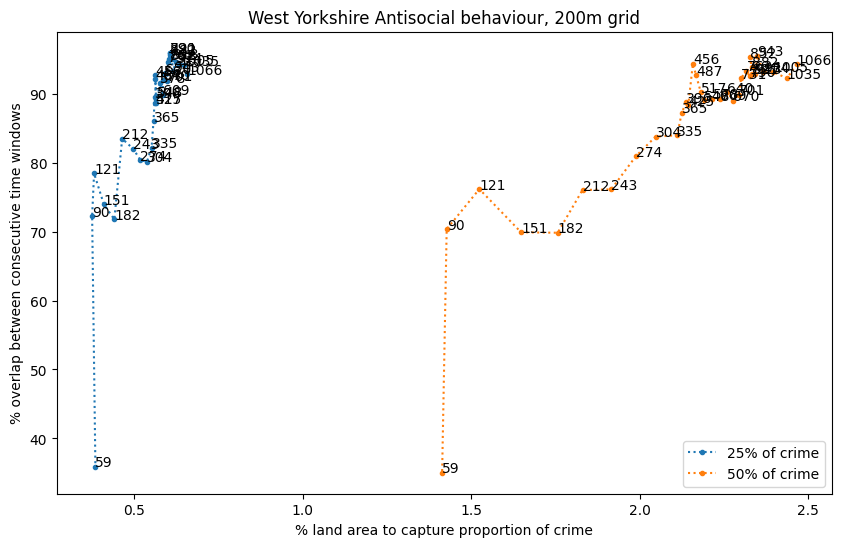

In [45]:
_, ax = plt.subplots(figsize=(10, 6))
ax.plot(both["25% of crime_land_area"], both["25% of crime"], label="25% of crime", ls=":", marker=".")
ax.plot(both["50% of crime_land_area"], both["50% of crime"], label="50% of crime", ls=":", marker=".")
ax.set_xlabel("% land area to capture proportion of crime")
ax.set_ylabel("% overlap between consecutive time windows")
ax.legend()

ax.set_title(f"West Yorkshire Antisocial behaviour, {grid_size}m grid")


for x, y, text in zip(both["25% of crime_land_area"], both["25% of crime"], both.days):
    plt.text(x, y, text)
for x, y, text in zip(both["50% of crime_land_area"], both["50% of crime"], both.days):
    plt.text(x, y, text)